# 📘 Threshold Pairs Trading Strategy

## 🎯 Goal of This Notebook

This notebook implements a **threshold-based pairs trading strategy** over multiple stock pairs. The aim is to evaluate whether a rules-based approach using historical relationships between pairs of stocks can lead to profitable trades during a test period.

## 📈 What is Threshold Pairs Trading?

**Pairs Trading** is a market-neutral strategy that profits from the relative movement of two historically correlated stocks. The **threshold strategy** enhances this by introducing entry and exit signals based on the **spread's deviation from its mean**.

### 🔁 Strategy Summary:
1. **Find a stable pair** of stocks.
2. **Calculate the spread** between them.
3. **Compute the mean and standard deviation** of the spread in a training period.
4. **Set thresholds** (e.g., ±2 standard deviations).
5. **Generate trading signals**:
   - If spread > upper threshold → Short the spread.
   - If spread < lower threshold → Long the spread.
6. **Exit** the position when the spread reverts to the mean.

## 🧪 Workflow in This Notebook:
- Load and preprocess historical stock prices.
- Load pre-identified stock pairs.
- Apply threshold-based trading logic to each pair.
- Evaluate trading performance on a test set.
- Visualize spread and signal behavior.

---

## **0. Initial Setup: Imports & Config**

This section imports essential libraries:

- `numpy`, `pandas`: Data handling
- `matplotlib`: Visualization
- `pickle`: File handling
- `sys`: System operations
- `timedelta`:Date-time operations

In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import matplotlib.pyplot as plt

## Trading Strategy Implementation with `Trading`

The `Trading` class implements and evaluates pairs trading strategies with comprehensive performance analysis. Key components include:

### Core Functionality
- **Strategy Application**: Implements fixed-beta pairs trading with configurable entry/exit thresholds
- **Performance Tracking**: Calculates returns, Sharpe ratios, and account balances with/without costs
- **Risk Management**: Incorporates transaction costs, short fees, and position stabilization

### Main Methods

#### Strategy Execution
- `apply_strategy()`: Main entry point that applies trading strategy to all identified pairs
- `threshold_strategy()`: Implements fixed-beta threshold strategy with spread normalization
- `calculate_returns()`: Computes position returns without transaction costs
- `calculate_balance()`: Tracks portfolio balance with full cost accounting

#### Performance Analysis
- `analyze_results()`: Comprehensive performance evaluation across all pairs
- `_calculate_sharpe()`: Computes annualized Sharpe ratio with risk-free rate adjustment
- `_calculate_max_drawdown()`: Calculates maximum drawdown statistics with visualization
- `_calculate_portfolio_sharpe()`: Computes portfolio-level Sharpe ratio

#### Supporting Utilities
- `trade_summary()`: Compiles complete trading performance summary
- `_add_transaction_costs()`: Models commission, market impact, and short fees
- `_add_trading_duration()`: Tracks holding periods for cost calculations

### Key Features
1. **Cost Modeling**:
   - Explicit modeling of commissions (0.28%)
   - Short fee accounting (1% annual)
   - Market impact costs

2. **Position Management**:
   - Stabilization period to avoid whipsaws
   - Automatic position sizing based on beta
   - Detailed trade duration tracking

3. **Performance Metrics**:
   - Annualized and cumulative returns
   - Win/loss trade statistics
   - Portfolio-level risk metrics
   - Interactive drawdown visualization

4. **Configuration Options**:
   - Adjustable entry/exit thresholds
   - Test/train mode selection
   - Custom split dates for walk-forward testing

In [2]:
sys.path.append('/Users/zahraaghaei/Desktop/PairsTrading_master/notebooks/classes')
%load_ext autoreload
%aimport DataProcessor, PairsTradingStrategy
%autoreload 1

# Create an instance of the DataProcessor and PairsTradingStrategy
processor = DataProcessor.DataProcessor()
strategy = PairsTradingStrategy.PairsTradingPortfolio()

## **1. Data Loading and Preparation**

This section handles the loading and partitioning of price data for pairs trading strategy development and testing.

In [3]:
df_prices = pd.read_pickle('/Users/zahraaghaei/Desktop/PairsTrading_master/Data/new_pickle/df_prices')

training_dates = ('01-01-2007', '31-12-2012')
testing_dates = ('01-01-2013', '31-12-2016')
train_val_split = '01-01-2010'
df_train, df_test = processor.split_data(df_prices, training_dates, testing_dates)
n_years_val = round(len(df_train[train_val_split:])/(240))

Total of 358 tickers
Total of 358 tickers after removing tickers with Nan values


### Precomputed Pair Data Loading

This section loads preprocessed pairs and ticker classification data from pickle files for use in the pairs trading strategy.

In [4]:
with open("/Users/zahraaghaei/Desktop/PairsTrading_master/data/new_pickle/pairs_category", 'rb') as handle:
    pairs_category = pickle.load(handle)
    
with open("/Users/zahraaghaei/Desktop/PairsTrading_master/data/new_pickle/pairs_OPTICS_unsupervised", 'rb') as handle:
    pairs_OPTICS = pickle.load(handle)

with open("/Users/zahraaghaei/Desktop/PairsTrading_master/data/new_pickle/ticker_category_dict", 'rb') as handle:
    ticker_category_dict = pickle.load(handle)
    
with open("/Users/zahraaghaei/Desktop/PairsTrading_master/data/new_pickle/ticker_segment_dict", 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

## Loading Optimal Weights from Pickle Files

This code snippet loads pre-computed optimal weights for pairs trading strategies from `pairs_category` and `pairs_OPTICS`:

In [5]:
with open("/Users/zahraaghaei/Desktop/PairsTrading_master/data/new_pickle/optimal_weights_dict_pairs_category", 'rb') as handle:
    optimal_weights_pairs_category = pickle.load(handle)

with open('/Users/zahraaghaei/Desktop/PairsTrading_master/data/new_pickle/optimal_weights_dict_pairs_OPTICS', 'rb') as handle:
    optimal_weights_pairs_OPTICS = pickle.load(handle)

In [6]:
optimal_weights_pairs_OPTICS

{'EMR_PH': 0.0,
 'GD_MDT': 22.8913,
 'GD_SYK': 11.9634,
 'MCK_WM': 0.0,
 'MDT_SYK': -38.5845,
 'MDT_ZBH': 15.6932,
 'SYK_ZBH': -10.8676,
 'KMB_MDLZ': 0.0,
 'DUK_PNW': 0.0,
 'ES_PNW': 0.0,
 'PNW_WEC': 0.0,
 'PNW_XEL': 0.0,
 'WEC_XEL': 0.0,
 'AMAT_GLW': 0.0,
 'PNR_UNP': 0.0,
 'CVX_OKE': 0.0,
 'COF_PNC': 0.0,
 'COF_WFC': 0.0,
 'MTB_WFC': 0.0,
 'DHI_LEN': 0.0,
 'AIV_MAC': 0.0,
 'HST_SLG': 0.0}

## **2. Strategy Execution and Performance Analysis on Trading Data with the same weights**

This section implements the pairs trading strategy and evaluates its performance metrics on `pairs_OPTICS_unsupervised` train data.

Initializing pairs trading strategy...
Processing pair 22/22

PAIRS TRADING STRATEGY PERFORMANCE RESULTS
Number of trading pairs: 22
Portfolio Sharpe Ratio: 5.21
Average Total ROI: 19.72%
Average Annual ROI: 6.18%
Percentage of Positive Trades: 58.37%
Percentage of Profitable Pairs: 95.45%

Risk Metrics:
Maximum Drawdown: 2.39%
Maximum Drawdown Duration: 41 days
Total Drawdown Duration: 323 days


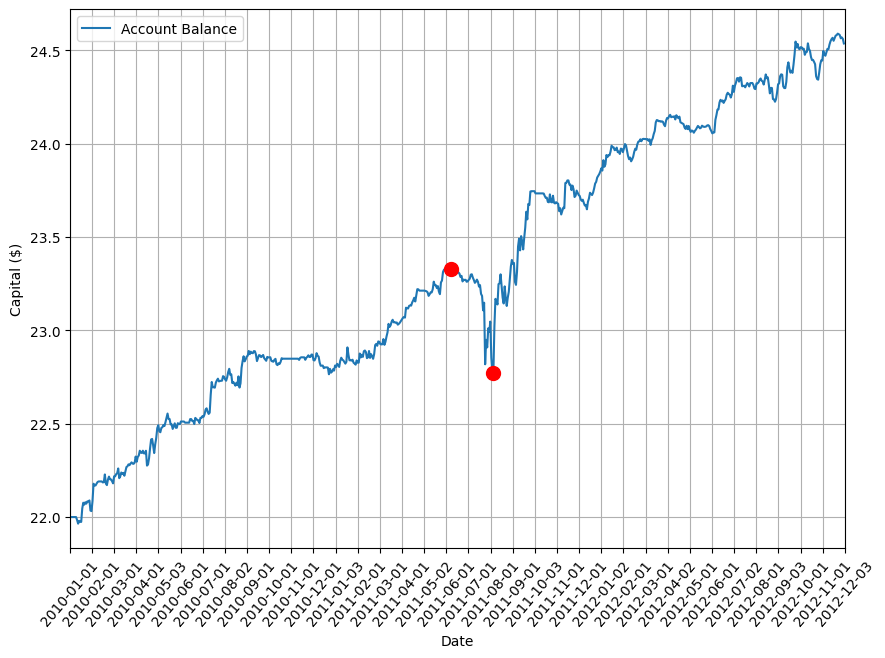

In [7]:
# Run strategy on pairs
(sharpe_results, cum_returns), (sharpe_with_costs, cum_returns_with_costs), results = strategy.apply_strategy(pairs_OPTICS)

# Summarize results with equal weights
metrics, pairs_df, portfolio = strategy.summarize_results(
    sharpe_results, cum_returns, results, 
    pairs_OPTICS, ticker_segment_dict, n_years = n_years_val
)

# Print the results with formatting
print("\n")
print("="*50)
print("PAIRS TRADING STRATEGY PERFORMANCE RESULTS")
print("="*50)
print(f"Number of trading pairs: {metrics['n_pairs']}")
print(f"Portfolio Sharpe Ratio: {metrics['portfolio_sharpe']:.2f}")
print(f"Average Total ROI: {metrics['avg_total_roi']:.2f}%")
print(f"Average Annual ROI: {metrics['avg_annual_roi']:.2f}%")
print(f"Percentage of Positive Trades: {metrics['positive_trades_pct']:.2f}%")
print(f"Percentage of Profitable Pairs: {metrics['positive_pairs_pct']:.2f}%")
print("\nRisk Metrics:")
print(f"Maximum Drawdown: {abs(metrics['max_drawdown']):.2f}%")
print(f"Maximum Drawdown Duration: {metrics['max_dd_duration']} days")
print(f"Total Drawdown Duration: {metrics['total_dd_duration']} days")
print("="*50)

## **2. Strategy Execution and Performance Analysis on Trading Data with the optimised weights**

This section implements the pairs trading strategy and evaluates its performance metrics on `pairs_OPTICS_unsupervised` train data.



WEIGHTED PAIRS TRADING STRATEGY PERFORMANCE RESULTS
Number of trading pairs: 22
Portfolio Sharpe Ratio: 5.21
Average Total ROI: 19.72%
Average Annual ROI: 6.18%
Percentage of Positive Trades: 58.37%
Percentage of Profitable Pairs: 95.45%

Risk Metrics:
Maximum Drawdown: 2.39%
Maximum Drawdown Duration: 41 days
Total Drawdown Duration: 323 days


/Users/zahraaghaei/Desktop/PairsTrading_master/notebooks/classes/PairsTradingStrategy.py:594: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1 + total_return) ** (252/len(portfolio)) - 1


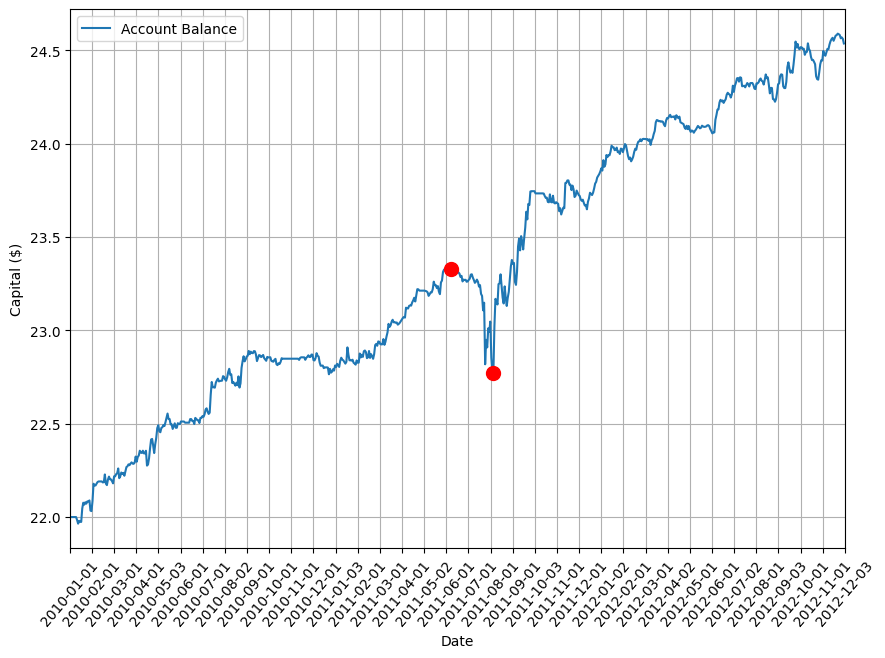

In [8]:
# with custom weights
weighted_metrics, weighted_pairs, weighted_portfolio = strategy.summarize_results(
    sharpe_results, cum_returns, results,
    pairs_OPTICS, ticker_segment_dict, n_years = n_years_val,
    weights = optimal_weights_pairs_OPTICS
)

# Print the results with formatting
print("\n")
print("="*50)
print("WEIGHTED PAIRS TRADING STRATEGY PERFORMANCE RESULTS")
print("="*50)
print(f"Number of trading pairs: {weighted_metrics['n_pairs']}")
print(f"Portfolio Sharpe Ratio: {weighted_metrics['portfolio_sharpe']:.2f}")
print(f"Average Total ROI: {weighted_metrics['avg_total_roi']:.2f}%")
print(f"Average Annual ROI: {weighted_metrics['avg_annual_roi']:.2f}%")
print(f"Percentage of Positive Trades: {weighted_metrics['positive_trades_pct']:.2f}%")
print(f"Percentage of Profitable Pairs: {weighted_metrics['positive_pairs_pct']:.2f}%")
print("\nRisk Metrics:")
print(f"Maximum Drawdown: {abs(weighted_metrics['max_drawdown']):.2f}%")
print(f"Maximum Drawdown Duration: {weighted_metrics['max_dd_duration']} days")
print(f"Total Drawdown Duration: {weighted_metrics['total_dd_duration']} days")
print("="*50)


## **3. Out-of-Sample Strategy: Execution and Performance Analysis on Testing Data with the same and the optimised weights**

This section evaluates the pairs trading strategy's performance on unseen `pairs_OPTICS` test data to validate its robustness.

Initializing pairs trading strategy...
Processing pair 22/22

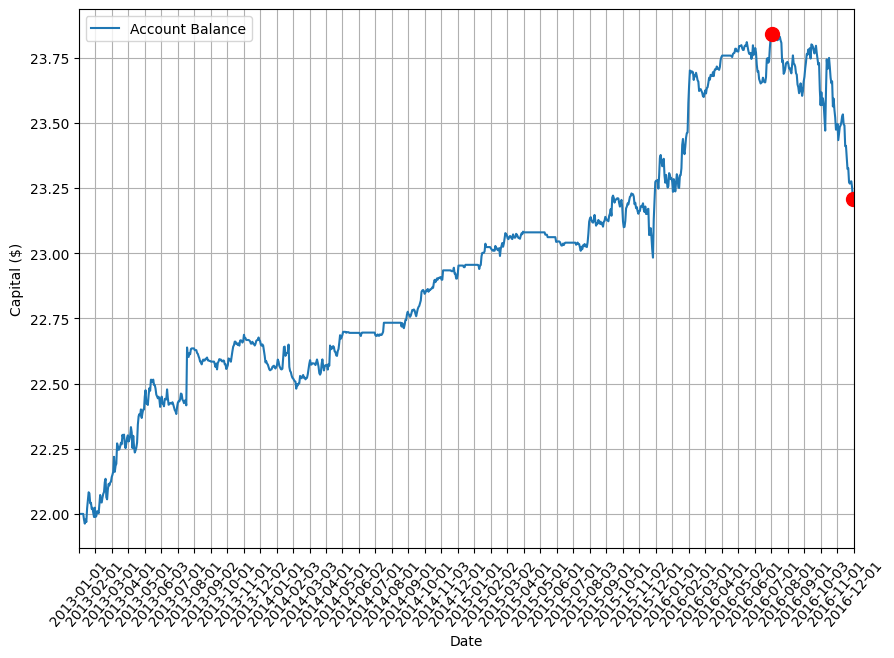

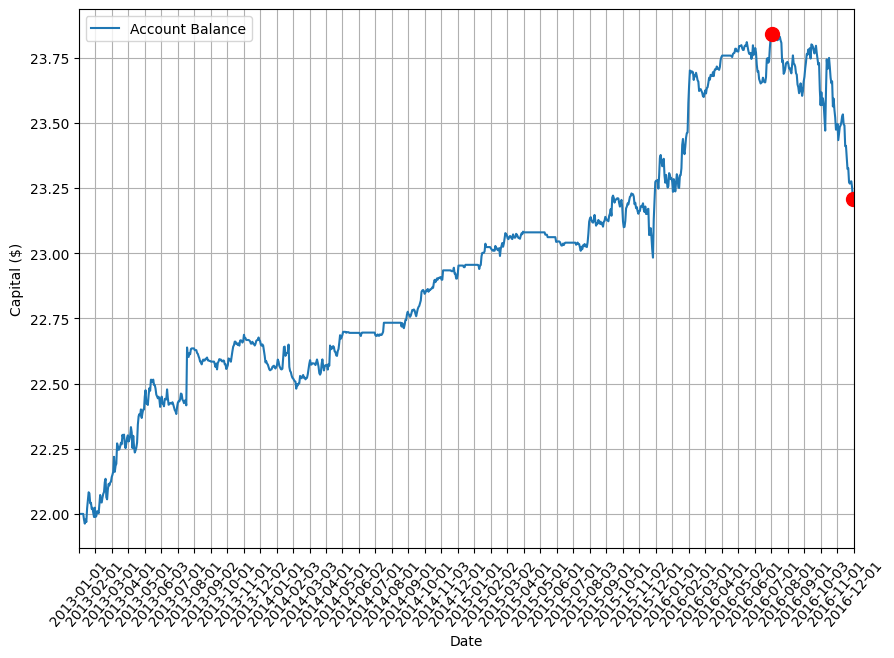

In [9]:
# Run strategy on pairs
(sharpe_results, cum_returns), (sharpe_with_costs, cum_returns_with_costs), results = strategy.apply_strategy(pairs_OPTICS, test_mode=True)

# Summarize results with equal weights
metrics, pairs_df, portfolio = strategy.summarize_results(
    sharpe_results, cum_returns, results, 
    pairs_OPTICS, ticker_segment_dict, n_years=n_years_val
)

weighted_metrics, weighted_pairs, weighted_portfolio = strategy.summarize_results(
    sharpe_results, cum_returns, results,
    pairs_OPTICS, ticker_segment_dict, n_years=n_years_val,
    weights=optimal_weights_pairs_OPTICS
)

In [10]:
# Print the results with formatting
print("\n")
print("="*50)
print("PAIRS TRADING STRATEGY PERFORMANCE RESULTS")
print("="*50)
print(f"Number of trading pairs: {metrics['n_pairs']}")
print(f"Portfolio Sharpe Ratio: {metrics['portfolio_sharpe']:.2f}")
print(f"Average Total ROI: {metrics['avg_total_roi']:.2f}%")
print(f"Average Annual ROI: {metrics['avg_annual_roi']:.2f}%")
print(f"Percentage of Positive Trades: {metrics['positive_trades_pct']:.2f}%")
print(f"Percentage of Profitable Pairs: {metrics['positive_pairs_pct']:.2f}%")
print("\nRisk Metrics:")
print(f"Maximum Drawdown: {abs(metrics['max_drawdown']):.2f}%")
print(f"Maximum Drawdown Duration: {metrics['max_dd_duration']} days")
print(f"Total Drawdown Duration: {metrics['total_dd_duration']} days")
print("="*50)



PAIRS TRADING STRATEGY PERFORMANCE RESULTS
Number of trading pairs: 22
Portfolio Sharpe Ratio: 3.25
Average Total ROI: 10.73%
Average Annual ROI: 3.46%
Percentage of Positive Trades: 53.42%
Percentage of Profitable Pairs: 77.27%

Risk Metrics:
Maximum Drawdown: 2.65%
Maximum Drawdown Duration: 105 days
Total Drawdown Duration: 402 days


In [11]:
# Print the results with formatting
print("\n")
print("="*50)
print("WEIGHTED PAIRS TRADING STRATEGY PERFORMANCE RESULTS")
print("="*50)
print(f"Number of trading pairs: {weighted_metrics['n_pairs']}")
print(f"Portfolio Sharpe Ratio: {weighted_metrics['portfolio_sharpe']:.2f}")
print(f"Average Total ROI: {weighted_metrics['avg_total_roi']:.2f}%")
print(f"Average Annual ROI: {weighted_metrics['avg_annual_roi']:.2f}%")
print(f"Percentage of Positive Trades: {weighted_metrics['positive_trades_pct']:.2f}%")
print(f"Percentage of Profitable Pairs: {weighted_metrics['positive_pairs_pct']:.2f}%")
print("\nRisk Metrics:")
print(f"Maximum Drawdown: {abs(weighted_metrics['max_drawdown']):.2f}%")
print(f"Maximum Drawdown Duration: {weighted_metrics['max_dd_duration']} days")
print(f"Total Drawdown Duration: {weighted_metrics['total_dd_duration']} days")
print("="*50)



WEIGHTED PAIRS TRADING STRATEGY PERFORMANCE RESULTS
Number of trading pairs: 22
Portfolio Sharpe Ratio: 3.25
Average Total ROI: 10.73%
Average Annual ROI: 3.46%
Percentage of Positive Trades: 53.42%
Percentage of Profitable Pairs: 77.27%

Risk Metrics:
Maximum Drawdown: 2.65%
Maximum Drawdown Duration: 105 days
Total Drawdown Duration: 402 days
